In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint, LearningRateScheduler # type: ignore
from sklearn.model_selection import train_test_split

from mcvd_transformer.dataset.parser import DataParser
from mcvd_transformer.dataset.dataloader import BatchGenerator
from mcvd_transformer.utils.objects import CoordinateSystem
from mcvd_transformer.model.model import create_model
from mcvd_transformer.model.callbacks import lr_scheduler, AdaptiveLossWeight
from mcvd_transformer.utils.postprocessing import PostProcessing
from mcvd_transformer.utils.evaluator import PerformanceEvaluator

EXPERIMENT_NAME = 'MCvD_Transformer'

2025-08-24 18:06:18.201549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-24 18:06:18.335702: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 18:06:18.957123: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ibrahim/miniconda3/envs/mcvd_transformer/lib/
2025-08-24 18:06:18.957230: W tensorflow/comp

Read MCvD Simulations

In [2]:
data_parser = DataParser("data", unwanted_folders=[".git"], include_prism=True)
data_set = data_parser.parse_data()

100%|██████████| 38119/38119 [03:52<00:00, 163.72it/s] 


Training Parameters

In [3]:
batch_size = 64
num_epochs = 400

data_seed = 1
numpy_seed = 10
dataloader_seed = 50

Split Dataset into Train, Validation and Test Parts

In [4]:
np.random.seed(numpy_seed)
np.random.shuffle(data_set)

train_set,test_val_set = train_test_split(data_set, test_size=0.3, random_state=data_seed)
val_set,test_set = train_test_split(test_val_set, test_size=0.33, random_state=data_seed)

del test_val_set

print(f"Size of Training Set = {len(train_set)}")
print(f"Size of Validation Set = {len(val_set)}")
print(f"Size of Test Set = {len(test_set)}")

Size of Training Set = 75880
Size of Validation Set = 21788
Size of Test Set = 10732


Create Batch Generators

In [5]:
training_batch_generator = BatchGenerator(
    train_set, 
    batch_size = batch_size, 
    coordinate_system = CoordinateSystem.BOTH, 
    random_rotate = True, 
    entity_order = "shuffle", 
    zero_padding = 10, 
    max_shape = True, 
    shuffle = True, 
    max_spherical_entity = 15,
    flatten = False,
    one_absorber_points = 0,
    random_seed=dataloader_seed
)

validation_batch_generator = BatchGenerator(
    val_set, 
    batch_size = batch_size, 
    coordinate_system = CoordinateSystem.BOTH, 
    random_rotate = True, 
    entity_order = "shuffle", 
    zero_padding = 10, 
    max_shape = True, 
    shuffle = True, 
    max_spherical_entity = 15,
    flatten = False,
    one_absorber_points = 0,
    random_seed=dataloader_seed
)

test_batch_generator = BatchGenerator(
    val_set, 
    batch_size = batch_size, 
    coordinate_system = CoordinateSystem.BOTH, 
    random_rotate = True, 
    entity_order = "shuffle", 
    zero_padding = 10, 
    max_shape = True, 
    shuffle = True, 
    max_spherical_entity = 15,
    flatten = False,
    one_absorber_points = 0,
    random_seed=dataloader_seed
)

In [11]:
for el in validation_batch_generator:
    print(el)

((array([[[  0.        ,   6.736072  ,  -1.2010046 , ...,   0.        ,
           0.        ,   0.        ],
        [  2.        ,   4.43348   ,   8.181034  , ...,   0.        ,
           0.        ,   0.        ],
        [ -1.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [ -1.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  1.        , -18.940128  ,  14.461641  , ...,   0.        ,
           0.        ,   0.        ],
        [  2.        , -10.794709  ,  -2.2072747 , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,  -7.88102   , -13.186035  , ...,   0.        ,
           0.        ,   0.        ],
        [  1.        ,   5.543262  ,   0.5986815 , ...,   0.        ,
           0.        ,   0.        ],
        [ -1.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...

KeyboardInterrupt: 

Create Model

In [6]:
model, alpha, beta = create_model(training_batch_generator[0][0][0].shape[1:], training_batch_generator[0][0][1].shape[1])
model.summary()

2025-08-24 18:10:14.544620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-24 18:10:14.584380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-24 18:10:14.584448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-24 18:10:14.585391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other ope

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 13)]     0           []                               
                                                                                                  
 transformer_block (Transformer  (None, 15, 13)      12382       ['input_1[0][0]']                
 Block)                                                                                           
                                                                                                  
 transformer_block_1 (Transform  (None, 15, 13)      12382       ['transformer_block[0][0]']      
 erBlock)                                                                                         
                                                                                              

Create Training Callbacks

In [13]:
# Create Experiment Log Folder
os.makedirs('experiments' + os.path.sep + EXPERIMENT_NAME, exist_ok=True)

filepath = 'experiments' + os.path.sep + EXPERIMENT_NAME + os.path.sep + 'model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_cir_max_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, LearningRateScheduler(lr_scheduler, verbose=0), AdaptiveLossWeight(alpha,beta)]

Run Training

In [8]:
history = model.fit(
    training_batch_generator,
    epochs = 5,
    verbose = 1,
    validation_data = validation_batch_generator,
    callbacks=callbacks_list
)

Epoch 1/5


2025-08-24 18:10:21.197933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1186/1186 [==============================] - ETA: 0s - loss: 0.2530 - shape_loss: 0.2282 - max_loss: 0.0249 - cir_loss: 0.0000e+00 - shape_r2_score: -1.2922 - shape_max_loss: 0.8057 - max_r2_score: -0.2553 - max_max_loss: 1.1832 - cir_r2_score: -77.0803 - cir_max_loss: 3.5508
Epoch 1: val_cir_max_loss did not improve from inf
1186/1186 [==============================] - 50s 37ms/step - loss: 0.2530 - shape_loss: 0.2282 - max_loss: 0.0249 - cir_loss: 0.0000e+00 - shape_r2_score: -1.2922 - shape_max_loss: 0.8057 - max_r2_score: -0.2553 - max_max_loss: 1.1832 - cir_r2_score: -77.0803 - cir_max_loss: 3.5508 - val_loss: nan - val_shape_loss: nan - val_max_loss: nan - val_cir_loss: nan - val_shape_r2_score: nan - val_shape_max_loss: nan - val_max_r2_score: nan - val_max_max_loss: nan - val_cir_r2_score: nan - val_cir_max_loss: nan - lr: 1.0000e-05
Epoch 2/5
1185/1186 [============================>.] - ETA: 0s - loss: 0.0447 - shape_loss: 0.0062 - max_loss: 0.0385 - cir_loss: 0.0000e+00 - sha

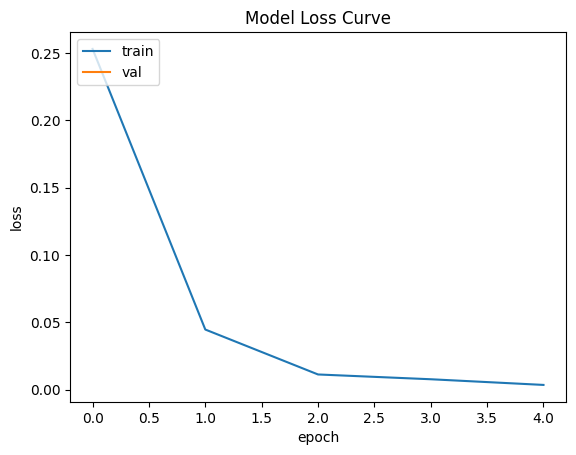

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss Curve')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'val'], loc='upper left')

Calculate Performance Metrics

In [ ]:
#model.load_weights(filepath)
model.load_weights("/home/ibrahim/MCvD-Transformer/model.keras")

train_error_values = PerformanceEvaluator.create_evaluation_results(
    model,
    data_set = train_set,
    coordinate_system = CoordinateSystem.BOTH,
    max_number_of_spherical = 15,
    order = "shuffle",
    path = 'experiments' + os.path.sep + EXPERIMENT_NAME + os.path.sep + "train_error.json"
)

val_error_values = PerformanceEvaluator.create_evaluation_results(
    model,
    data_set = val_set,
    coordinate_system = CoordinateSystem.BOTH,
    max_number_of_spherical = 15,
    order = "shuffle",
    path = 'experiments' + os.path.sep + EXPERIMENT_NAME + os.path.sep + "val_error.json"
)

test_error_values = PerformanceEvaluator.create_evaluation_results(
    model,
    data_set = test_set,
    coordinate_system = CoordinateSystem.BOTH,
    max_number_of_spherical = 15,
    order = "shuffle",
    path = 'experiments' + os.path.sep + EXPERIMENT_NAME + os.path.sep + "test_error.json"
)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'experiments/MCvD_Transformer/model.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Plot Raw Estimations

In [ ]:
index = 277
input_topology = val_set[index].rotate(10,45)

input_top,input_num = input_topology.convert_numpy(CoordinateSystem.BOTH,15,"shuffle",False)
shape,max_value,_ = model.predict([np.expand_dims(input_top,axis=0),np.expand_dims(input_num,axis=0)])

prediction = PostProcessing.postprocessing_separate(shape[0],max_value[0])

PerformanceEvaluator.time_graph(
    time_output_actual = input_topology.time_output,
    time_output_predicted_list = [prediction],
    legend=["Ground Truth", "Prediction"],
    image_loc=None,
    time_res=1,
    expension_ratio=1,
    path=None
)

Visualize Topology

In [ ]:
input_topology.visualize()